In [92]:
# Initialize Modules

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
import sys 
import os
import pickle
import librosa
import librosa.display
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras import metrics

### Data Processing

In [93]:
# Load Dataset
df = pd. read_csv("./data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [94]:
# Cleaning Data
df=df.drop(labels="filename", axis=1)

### Feature Extraction

Preprocessing of data is required before we finally train the data. We will try and focus on the last column that is ‘label’ and will encode it with the function LabelEncoder() of sklearn.preprocessing.

In [95]:
class_list=df.iloc[:,-1]
converter = LabelEncoder()

In [96]:
y=converter.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [97]:
# Saving Classification Converter
pickle.dump(converter, open("./model/classes.pkl", "wb"))

In [98]:
# Scaling the Features
fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))
X

array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
         0.12841417, -0.29178072],
       [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
         1.27578001,  0.05642464],
       [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
         0.30333409, -0.95893743],
       [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
        -0.47495901, -0.55112155]])

In [99]:
# Saving Scalar
pickle.dump(fit, open("./model/scaler.pkl", "wb"))

In [100]:
# Creating Train/Test Split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)
print("Amount to Train: ", len(y_train))
print("Amount to Test: ", len(y_test))

Amount to Train:  6693
Amount to Test:  3297


### Model Building

In [101]:
def train_model(model,epochs, b_size, optimizer):
    batch_size=b_size
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

def plot_validate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

def plot_accuracy(history, epochs, b_size):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    title = "Model Accuracy: " + str(epochs) + " Epochs, " + str(b_size) + " batch size"
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def plot_loss(history, epochs, b_size):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    title = "Model Loss: " + str(epochs) + " Epochs, " + str(b_size) + " batch size"
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [102]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 512)               30208     
                                                                 
 dropout_48 (Dropout)        (None, 512)               0         
                                                                 
 dense_61 (Dense)            (None, 256)               131328    
                                                                 
 dropout_49 (Dropout)        (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 128)               32896     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 64)              

Epoch 1/500
53/53 [==============================] - 0s 4ms/step - loss: 1.6552 - accuracy: 0.4022 - val_loss: 1.1564 - val_accuracy: 0.5951
Epoch 2/500
53/53 [==============================] - 0s 3ms/step - loss: 1.1622 - accuracy: 0.5949 - val_loss: 0.8913 - val_accuracy: 0.6918
Epoch 3/500
53/53 [==============================] - 0s 3ms/step - loss: 0.9324 - accuracy: 0.6807 - val_loss: 0.7853 - val_accuracy: 0.7325
Epoch 4/500
53/53 [==============================] - 0s 3ms/step - loss: 0.8011 - accuracy: 0.7318 - val_loss: 0.6900 - val_accuracy: 0.7643
Epoch 5/500
53/53 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.7648 - val_loss: 0.6211 - val_accuracy: 0.7868
Epoch 6/500
53/53 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.7895 - val_loss: 0.5696 - val_accuracy: 0.8120
Epoch 7/500
53/53 [==============================] - 0s 3ms/step - loss: 0.5688 - accuracy: 0.8144 - val_loss: 0.5536 - val_accuracy: 0.8147
Epoch 8/500
5

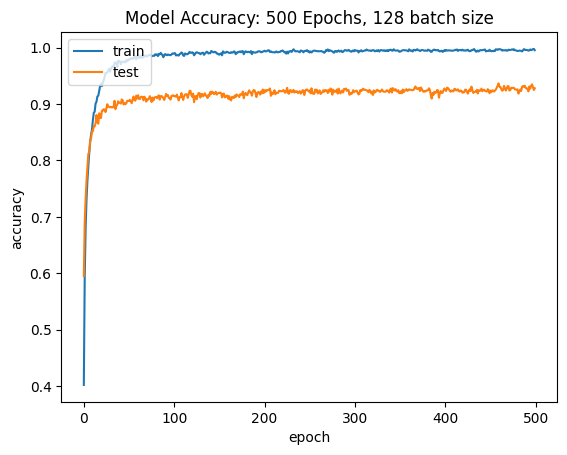

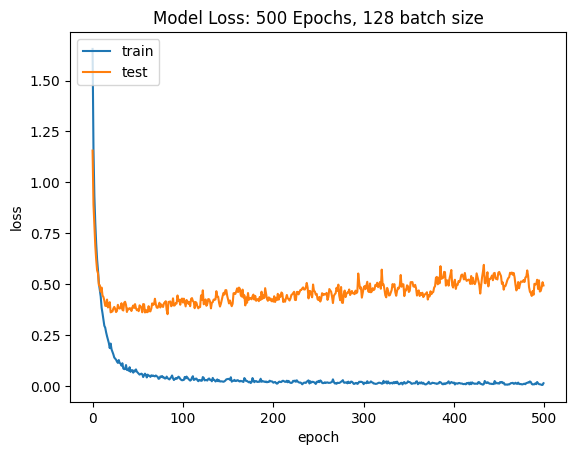

In [103]:
model_history=train_model(model=model,epochs=500, b_size=128, optimizer='adam')
plot_accuracy(model_history, 500, 128)
plot_loss(model_history, 500, 128)

Epoch 1/100
105/105 [==============================] - 0s 3ms/step - loss: 1.5337 - accuracy: 0.4520 - val_loss: 1.0459 - val_accuracy: 0.6309
Epoch 2/100
105/105 [==============================] - 0s 3ms/step - loss: 1.0348 - accuracy: 0.6440 - val_loss: 0.7977 - val_accuracy: 0.7346
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 0.8490 - accuracy: 0.7115 - val_loss: 0.6796 - val_accuracy: 0.7658
Epoch 4/100
105/105 [==============================] - 0s 2ms/step - loss: 0.7205 - accuracy: 0.7597 - val_loss: 0.6353 - val_accuracy: 0.7831
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.7877 - val_loss: 0.5739 - val_accuracy: 0.8041
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.8180 - val_loss: 0.5386 - val_accuracy: 0.8165
Epoch 7/100
105/105 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.8389 - val_loss: 0.5074 - val_accuracy: 0.8338

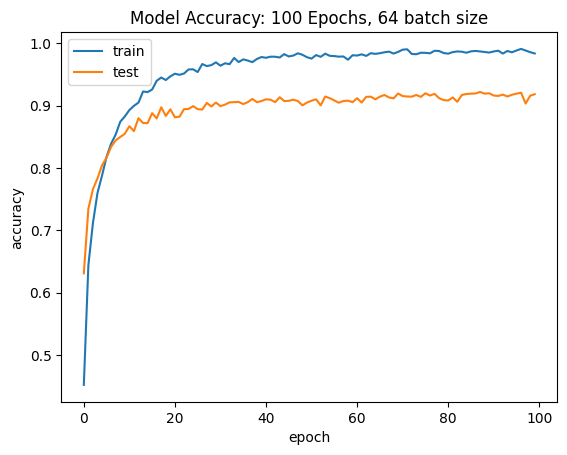

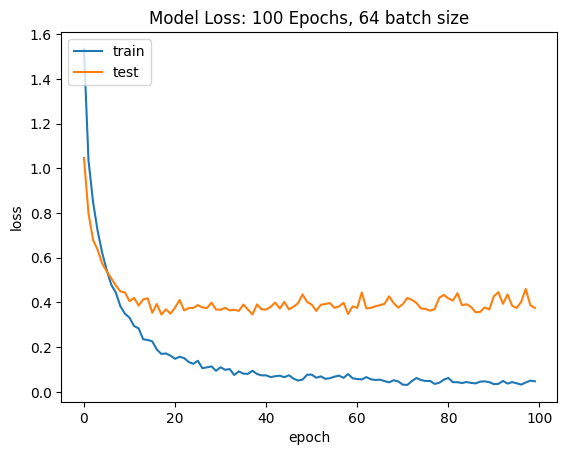

In [104]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

model_history=train_model(model=model,epochs=100, b_size=64, optimizer='adam')
plot_accuracy(model_history, 100, 64)
plot_loss(model_history, 100, 64)

Epoch 1/100
53/53 [==============================] - 0s 4ms/step - loss: 1.6444 - accuracy: 0.4025 - val_loss: 1.1339 - val_accuracy: 0.6115
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 1.1381 - accuracy: 0.6020 - val_loss: 0.8956 - val_accuracy: 0.6970
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.9068 - accuracy: 0.6949 - val_loss: 0.7631 - val_accuracy: 0.7452
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7984 - accuracy: 0.7261 - val_loss: 0.6722 - val_accuracy: 0.7810
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.7660 - val_loss: 0.6631 - val_accuracy: 0.7859
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.7850 - val_loss: 0.6106 - val_accuracy: 0.8013
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.5840 - accuracy: 0.8076 - val_loss: 0.5832 - val_accuracy: 0.8089
Epoch 8/100
5

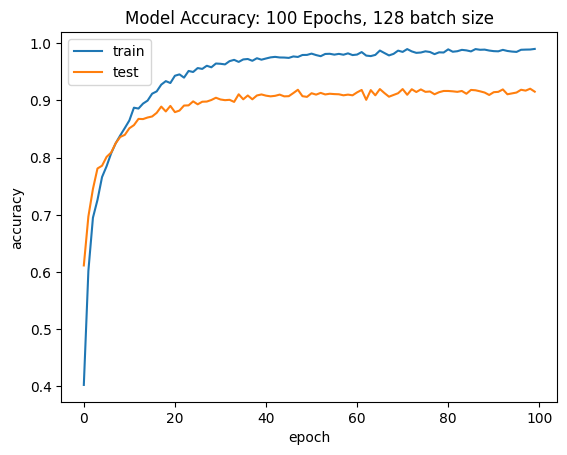

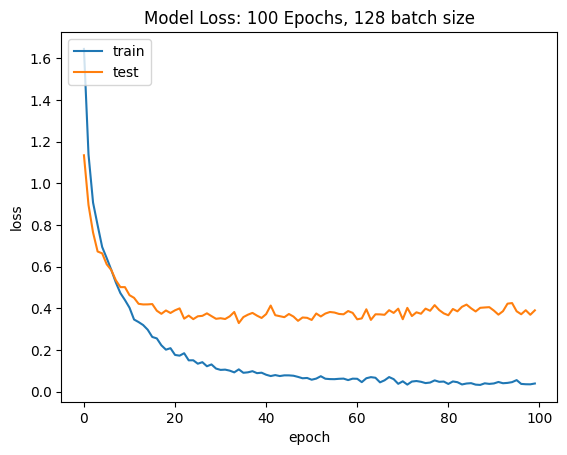

In [105]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])
model_history=train_model(model=model,epochs=100, b_size=128, optimizer='adam')
plot_accuracy(model_history, 100, 128)
plot_loss(model_history, 100, 128)

In [106]:
# Saving Model for Use
model.save('./model/model.keras')

### Model Evaluation

In [107]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is ", test_loss)
print("The best accuracy is: ", test_acc*100)

26/26 [==============================] - 0s 900us/step - loss: 0.3897 - accuracy: 0.9154
The test loss is  0.3897009789943695
The best accuracy is:  91.53776168823242


In [108]:
y_pred1 = model.predict(X_test, batch_size=128)
y_pred = np.argmax(y_pred1, axis=1)

26/26 [==============================] - 0s 1ms/step


In [109]:
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
result = confusion_matrix(y_test, y_pred , normalize='pred')

In [110]:
for i in range(len(result)):
    for j in range(len(result[i])):
        result[i][j] = round(result[i][j], 2)

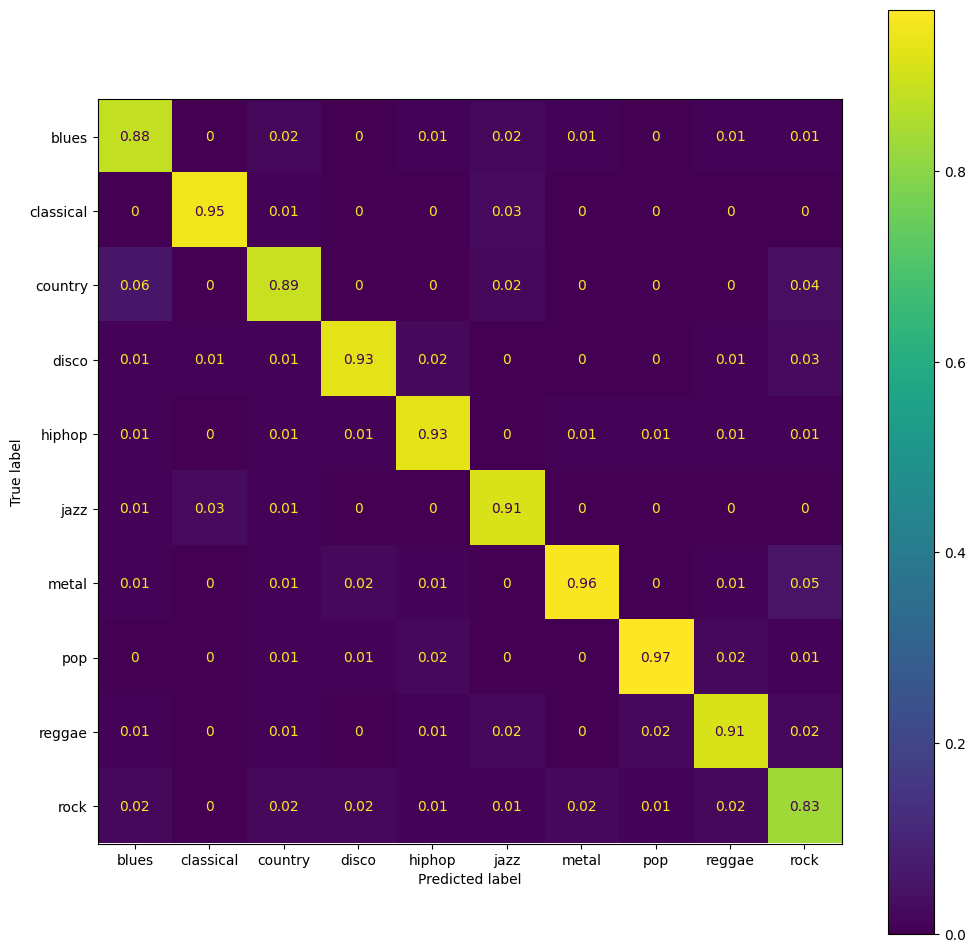

In [111]:
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size here (width, height)
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=classes)
disp.plot(ax=ax)
plt.show()